In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, min as spark_min, array, udf
from pyspark.sql.types import ArrayType, IntegerType
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import BisectingKMeans
import matplotlib.pyplot as plt
import shutil
import glob
import os


spark = (SparkSession.builder
    .appName("HotelClustering")
    .master("local[*]")
    .config("spark.driver.memory", "8g")
    .config("spark.executor.memory", "8g")
    .config("spark.sql.shuffle.partitions", "8")
    .config("spark.sql.execution.arrow.pyspark.enabled", "true")
    .getOrCreate()
)

In [ ]:
file_path = "Data/Hotels_data_Changed.csv"
df = spark.read.csv(file_path, header=True, inferSchema=True)
df.show(5)

+-------------+------------+----+--------------+--------------+-------------+---------------+--------------------+-----------+-------+---------+------------+------------------+
|Snapshot Date|Checkin Date|Days|Original Price|Discount Price|Discount Code|Available Rooms|          Hotel Name|Hotel Stars|DayDiff|  WeekDay|DiscountDiff|      DiscountPerc|
+-------------+------------+----+--------------+--------------+-------------+---------------+--------------------+-----------+-------+---------+------------+------------------+
|   2015-07-17|  2015-08-12|   5|          1178|          1040|            1|              6|Best Western Plus...|          3|     26|Wednesday|         138|11.714770797962649|
|   2015-07-17|  2015-08-19|   5|          1113|           982|            1|              8|Best Western Plus...|          3|     33|Wednesday|         131|11.769991015274034|
|   2015-07-17|  2015-08-13|   5|          4370|          4240|            1|              3|The Peninsula New...| 

In [3]:
hotel_counts = df.groupBy("Hotel Name").agg(count("Hotel Name").alias("count"))
top_hotels = hotel_counts.orderBy(col("count").desc()).limit(150)
df = df.join(top_hotels, "Hotel Name")
df.show(5)

+--------------------+-------------+------------+----+--------------+--------------+-------------+---------------+-----------+-------+---------+------------+------------------+-----+
|          Hotel Name|Snapshot Date|Checkin Date|Days|Original Price|Discount Price|Discount Code|Available Rooms|Hotel Stars|DayDiff|  WeekDay|DiscountDiff|      DiscountPerc|count|
+--------------------+-------------+------------+----+--------------+--------------+-------------+---------------+-----------+-------+---------+------------+------------------+-----+
|The Peninsula New...|   2015-07-17|  2015-08-13|   5|          4370|          4240|            1|              3|          5|     27| Thursday|         130|2.9748283752860414|  811|
|Eventi Hotel a Ki...|   2015-07-17|  2015-07-26|   5|          1739|          1667|            1|             18|          4|      9|   Sunday|          72| 4.140310523289246|  617|
|Eventi Hotel a Ki...|   2015-07-17|  2015-08-12|   5|          1739|          1672| 

In [4]:
df_grouped = df.groupBy("Hotel Name", "Checkin Date", "Discount Code").agg(spark_min("Discount Price").alias("Min Price"))
df_grouped = df_grouped.withColumn("date_code", col("Checkin Date").cast("string"))
pivot_df = df_grouped.groupBy("Hotel Name").pivot("date_code").agg(spark_min("Min Price"))
pivot_df = pivot_df.fillna(-1)
pivot_df.show(5)

+--------------------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------

In [5]:
def normalize_prices(prices):
    valid_prices = [p for p in prices if p != -1]
    if not valid_prices:
        return prices
    min_price, max_price = min(valid_prices), max(valid_prices)
    if min_price == max_price:
        return [0 if p != -1 else -1 for p in prices]
    normalized = []
    for p in prices:
        if p == -1:
            normalized.append(-1)
        else:
            norm_val = round(((p - min_price) / (max_price - min_price)) * 100)
            normalized.append(int(norm_val))
    return normalized

normalize_udf = udf(normalize_prices, ArrayType(IntegerType()))

numeric_columns = [c for c in pivot_df.columns if c != "Hotel Name"]
pivot_df = pivot_df.withColumn("prices_array", array(*numeric_columns))
pivot_df = pivot_df.withColumn("norm_prices_array", normalize_udf("prices_array"))

for i, col_name in enumerate(numeric_columns):
    pivot_df = pivot_df.withColumn(col_name, col("norm_prices_array")[i])

df_final = pivot_df.drop("prices_array", "norm_prices_array")


In [6]:
df_final.show(5)


+--------------------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------

In [7]:
final_output_path = "./Data/PySpark_hotels_clustering_data.csv"
temp_output_folder = "./Data/temp_csv"

df_final.coalesce(1).write.mode("overwrite").option("header", "true").csv(temp_output_folder)

import shutil, glob, os
csv_file = glob.glob(f"{temp_output_folder}/part-*.csv")[0]
shutil.move(csv_file, final_output_path)

shutil.rmtree(temp_output_folder)

print("Saved successfully!")

Saved successfully!


In [8]:
feature_cols = [c for c in df_final.columns if c != "Hotel Name"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df_features = assembler.transform(df_final).select("Hotel Name", "features")

In [9]:
k = 5
bkm = BisectingKMeans(featuresCol="features", k=k, seed=42)
model = bkm.fit(df_features)

In [10]:
df_clusters = model.transform(df_features)
df_clusters.select("Hotel Name", "prediction").show(20, truncate=False)


+---------------------------------------------------------+----------+
|Hotel Name                                               |prediction|
+---------------------------------------------------------+----------+
|Conrad New York                                          |4         |
|W New York Times Square                                  |3         |
|Hyatt Herald Square New York                             |4         |
|Eventi Hotel a Kimpton Hotel                             |2         |
|Home2 Suites by Hilton NY Long Island City Manhattan View|3         |
|Cassa Hotel 45th Street                                  |4         |
|The St. Regis New York                                   |2         |
|Wyndham Garden Brooklyn Sunset Park                      |4         |
|Comfort Inn Times Square South Area                      |3         |
|Best Western Bayside Inn                                 |3         |
|Wyndham Garden Chinatown                                 |0         |
|Doubl

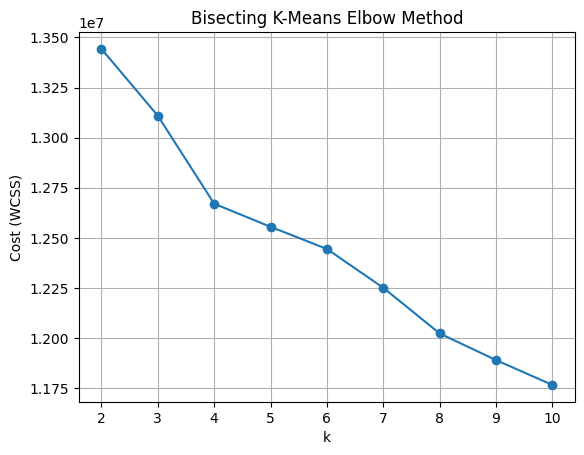

In [11]:
cost = []
for k in range(2, 11):
    bkm = BisectingKMeans(featuresCol="features", k=k, seed=42)
    model = bkm.fit(df_features)
    cost.append(model.summary.trainingCost)

# plot elbow graph
import matplotlib.pyplot as plt

plt.plot(range(2, 11), cost, marker='o')
plt.xlabel('k')
plt.ylabel('Cost (WCSS)')
plt.title('Bisecting K-Means Elbow Method')
plt.grid()
plt.show()

**We Identify the Elbow:**

The optimal k is usually at the point where the rate of decrease in cost begins to slow down significantly (the "elbow" point), and we identify this point in k=4 so now will train the again.


In [14]:
optimal_k = 4
bkm = BisectingKMeans(featuresCol="features", k=optimal_k, seed=42)
model = bkm.fit(df_features)
df_clustered = model.transform(df_features)
df_clustered.select("Hotel Name", "prediction").show(10, truncate=False)

+---------------------------------------------------------+----------+
|Hotel Name                                               |prediction|
+---------------------------------------------------------+----------+
|Conrad New York                                          |3         |
|W New York Times Square                                  |2         |
|Hyatt Herald Square New York                             |3         |
|Eventi Hotel a Kimpton Hotel                             |1         |
|Home2 Suites by Hilton NY Long Island City Manhattan View|2         |
|Cassa Hotel 45th Street                                  |3         |
|The St. Regis New York                                   |1         |
|Wyndham Garden Brooklyn Sunset Park                      |3         |
|Comfort Inn Times Square South Area                      |2         |
|Best Western Bayside Inn                                 |2         |
+---------------------------------------------------------+----------+
only s

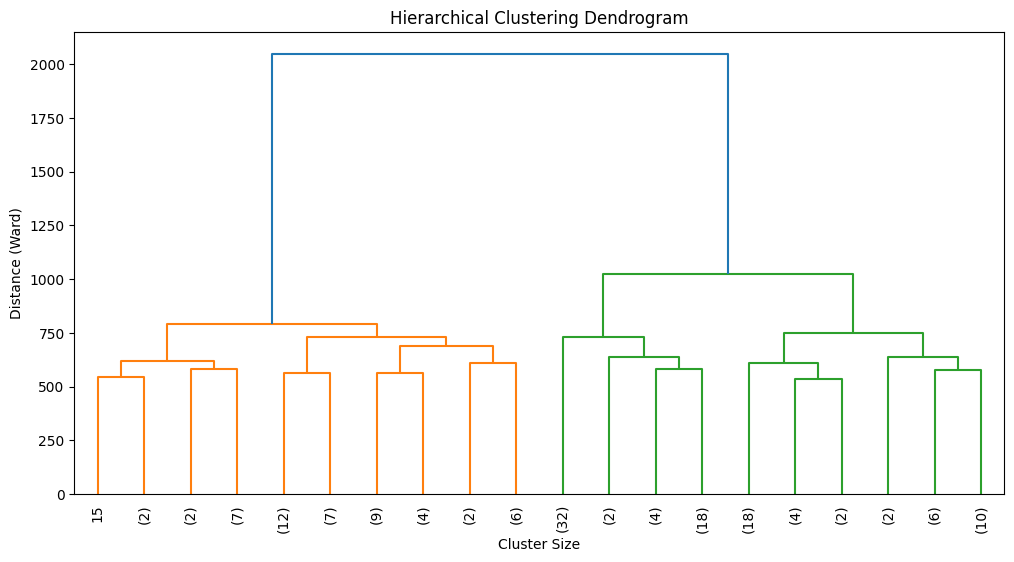

In [15]:
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt


pdf_features = df_features.select("features").toPandas()
X = np.vstack(pdf_features['features'].values)


linked = linkage(X, 'ward')


plt.figure(figsize=(12, 6))
dendrogram(linked,truncate_mode='lastp', p=20, leaf_rotation=90, leaf_font_size=10)

plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Cluster Size')
plt.ylabel('Distance (Ward)')
plt.show()

In [16]:
from pyspark.ml.feature import PCA
import plotly.express as px

pca = PCA(k=2, inputCol="features", outputCol="pcaFeatures")
pca_model = pca.fit(df_clusters)
df_pca = pca_model.transform(df_clusters)


pandas_df = df_pca.select("Hotel Name", "prediction", "pcaFeatures").toPandas()

pandas_df["pca1"] = pandas_df["pcaFeatures"].apply(lambda x: x[0])
pandas_df["pca2"] = pandas_df["pcaFeatures"].apply(lambda x: x[1])

fig = px.scatter(pandas_df ,x="pca1" ,y="pca2" ,color="prediction" ,hover_data=["Hotel Name"] ,title="Hotel Clusters Visualization (PCA Reduced to 2D)"
)

fig.show()


**The Clusters Visualization (PCA Reduced to 2D) does not appear here but is saved as png in the Data folder.**

In [ ]:
spark.stop()